In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import regex as re

In [8]:
k = 31

### AalbF5 chromosome 1
# based on fasta file
nb_nucleotides = 338_177_654    # grep -v '^>' AalbF5_chr1.fna | tr -d '\n' | wc -c     # coincides exactly with NCBI indication
nb_ACGT = 155_552_214           # grep -v '^>' AalbF5_chr1.fna | tr -cd ACGT | wc -c
nb_acgt = 182_182_218           # grep -v '^>' AalbF5_chr1.fna | tr -cd acgt | wc -c
nb_N = 443_222                  # grep -v '^>' AalbF5_chr1.fna | tr -cd N | wc -c

nb_patches_N = 8562             # grep -v '^>' AalbF5_chr1.fna | grep -oP 'N+'| wc -l   # note: pb with patches gapping lines/ at start or end of seq

# based on rust code
nb_total_31mers = 337_698_822   # with duplicates           # coincides ~ with: nb_nucleotides - nb_N - (k-1) * (nb_patches_N+1)
nb_nocan_31mers = 247_347_254   # without duplicates
nb_canon_31mers = 232_971_101   # without duplicates

### graph AalbF3 + AalbF5 (k31, canonical)
nb_nodes = 376_592_961
nb_edges = 383_504_450

### graph AalbF5 (k31, canonical)
nb_nodes = 232_971_101
nb_edges = 236_446_568

### graph AalbF5 (k32, canonical)
nb_nodes = 235_350_021

### walktrough of AalbF5 (canonical)
nb_breaks_one_haplo = 46_619_218
nb_breaks_two_haplo = 55_574_344


In [ ]:
# Input graph: only AalbF3
#   - 255_874_974 nodes
#   - 259_767_078 edges
# Haplo contains:
#   - kmers: 373_823_221
#   - breakpoints: 52_598_113  (>1)      217  (<1)

# Input graph: only AalbF5
#   - 232_971_101 nodes
#   - 236_446_568 edges
# Haplo contains:
#   - kmers: 337_698_822
#   - breakpoints: 46_619_218  (>1)      862  (<1)

# Input graph: both haplo
#    - 376_592_961 nodes
#    - 383_504_450 edges
# Haplo AalbF3 contains:
#    - 373_823_221 kmers
#    - breakpoints: 60_820_242  (>1)     188  (<1)
# Haplo AalbF5 contains:
#    - 337_698_822 kmers
#    - breakpoints: 55_574_344  (>1)     470  (<1)

In [10]:
def parse_checkpoints(fasta_file):
    """Parse checkpoints"""
    headers = []
    nb_unitigs = []
    start_pos = []
    
    current_header = None
    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                # If we were working on a sequence, save it
                if current_header is not None:
                    headers.append(current_header)
                    nb_unitigs.append(curr_nb_unitigs)
                    start_pos.append(curr_start_pos)

                # Start a new sequence
                current_header = line[1:]  # Remove the '>' character
                curr_nb_unitigs = []
                curr_start_pos = []
            elif line:
                line = line.split(":", 1)[0]
                line_parts = line.split()
                curr_nb_unitigs.append(int(line_parts[0]))
                curr_start_pos.append(int(line_parts[-1]))
    
    # Don't forget to save the last sequence
    if current_header is not None:
        headers.append(current_header)
        nb_unitigs.append(curr_nb_unitigs)
        start_pos.append(curr_start_pos)
    
    return headers, nb_unitigs, start_pos

def parse_checkpoints_merged(fasta_file):
    nb_unitigs = []
    start_pos = []
    
    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                continue
            elif line:
                line = line.split(":", 1)[0]
                line_parts = line.split()
                nb_unitigs.append(int(line_parts[0]))
                start_pos.append(int(line_parts[-1]))
    
    return nb_unitigs, start_pos

from collections import deque

def count_repetitions(file, max_size_pattern=3, min_nb_patterns=3, verbose=False):
    repeats = []
    
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            # Initialize the deque and repeat counts when a new header is found
            if line.startswith('>'):
                nb_repeats = [0 for _ in range(max_size_pattern)]
                line_history = deque(maxlen=max_size_pattern)
            elif line:
                # Process the line to extract unitig information
                line_info, line_nodes = line.split(":", 1)
                line_info = line_info.split()
                nb_unitigs = line_info[0]
                line_position = line_info[-1]
                for size in range(1, max_size_pattern+1):
                    # Check if the current line elongates a repated pattern
                    if len(line_history) >= size and (nb_unitigs, line_nodes) == line_history[-size]:
                        nb_repeats[size-1] += 1
                    else:
                        # Verify if the previous pattern was repeated enough times
                        if size+nb_repeats[size-1] >= size*min_nb_patterns:
                            repeats += [int(line_history[-i][0]) for i in range(1, size+1)]*(1+nb_repeats[size-1]//size)
                            if verbose:
                                print(f"Found unitig pattern ({','.join([line_history[-i][0] for i in range(1, size+1)])}) repeated {1+(nb_repeats[size-1])/size} times at position {line_position}")
                            nb_repeats = [0 for _ in range(max_size_pattern)]
                        nb_repeats[size-1] = 0
                line_history.append((nb_unitigs, line_nodes))
    return repeats

In [11]:
path_1_hap = "output/chr1/checkpoints_AalbF5_in_1.fna"
path_2_hap = "output/chr1/checkpoints_AalbF5_in_2.fna"

In [12]:
repeats_1 = count_repetitions(path_1_hap, max_size_pattern=3, min_nb_patterns=3, verbose=True)

Found unitig pattern (1) repeated 16.0 times at position 2015
Found unitig pattern (11) repeated 4.0 times at position 221
Found unitig pattern (11) repeated 16.0 times at position 456
Found unitig pattern (11) repeated 14.0 times at position 693
Found unitig pattern (11) repeated 10.0 times at position 947
Found unitig pattern (11) repeated 4.0 times at position 1081
Found unitig pattern (11) repeated 20.0 times at position 1372
Found unitig pattern (3) repeated 4.0 times at position 19975
Found unitig pattern (13,8,13) repeated 35.0 times at position 21797
Found unitig pattern (13,8,13) repeated 21.0 times at position 22997
Found unitig pattern (13,8,13) repeated 7.0 times at position 23525
Found unitig pattern (4) repeated 15.0 times at position 49086
Found unitig pattern (2) repeated 25.0 times at position 104412
Found unitig pattern (2) repeated 30.0 times at position 182678
Found unitig pattern (1) repeated 8.0 times at position 228341
Found unitig pattern (6) repeated 73.0 times

In [13]:
nb_unitigs_1_hap, start_pos_1_hap = parse_checkpoints_merged(path_1_hap)
nb_unitigs_2_hap, start_pos_2_hap = parse_checkpoints_merged(path_2_hap)

repeats_1 = count_repetitions(path_1_hap, max_size_pattern=3, min_nb_patterns=3)
repeats_2 = count_repetitions(path_2_hap, max_size_pattern=3, min_nb_patterns=3)

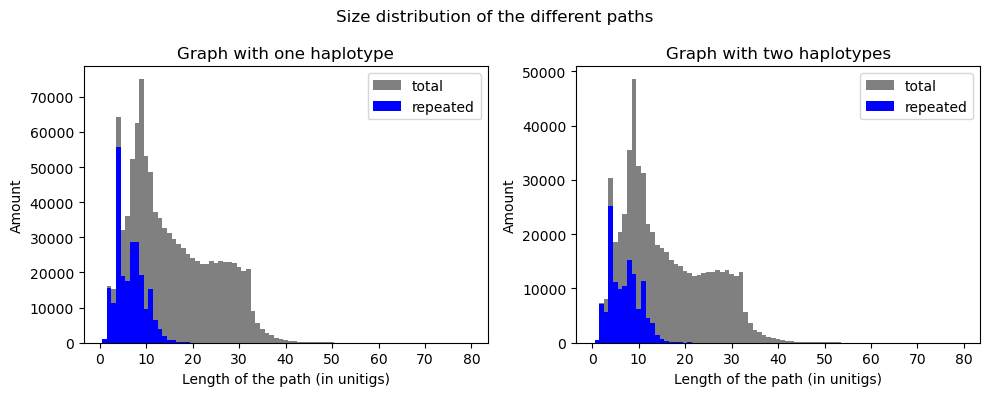

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
nb_unitigs = [nb_unitigs_1_hap, nb_unitigs_2_hap]
repeats = [repeats_1, repeats_2]

for i in range(2):
    axs[i].hist(nb_unitigs[i], color='grey', bins=np.arange(0.5, 80.5, 1), label='total', density=False)
    axs[i].hist(repeats[i], color='blue', bins=np.arange(0.5, max(repeats[i]) + 1.5, 1), label='repeated', density=False)
    axs[i].set_title("Graph with one haplotype" if i == 0 else "Graph with two haplotypes")
    axs[i].set_xlabel('Length of the path (in unitigs)')
    axs[i].set_ylabel('Amount')
    axs[i].legend()
plt.suptitle('Size distribution of the different paths')
plt.tight_layout()
plt.show()